In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import time
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import Environment, EnvironmentMeanField
from src.runner import runner, runner_mean_field
from src.helpers import confidence_interval
from sklearn import preprocessing
import random
import json
import geopy.distance
import os

In [2]:
style.use('seaborn-white')

# Policy experiments

There are **five policy instruments:**

1. Physical distancing measures such as increased hygiëne & face mask adoption 
2. Travel restriction multiplier
3. Reducing close / family contacts 
4. Testing and general awareness
5. limiting mass contact e.g. forbidding large events

Effect of the policy instruments on **3 outcomes:**

1. total infected = end of simulation recovered + dead

2. total casualties = end of simulation dead

3. peak critical = max(critical) 

### Setting up the experiments

First, load the parameters

In [3]:
with open('parameters/parameters.json') as json_file:
    parameters = json.load(json_file)

In [4]:
parameters

{'time': 120,
 'number_of_agents': 1000,
 'monte_carlo_runs': 1,
 'data_output': 'csv',
 'share_inital_agents_infected': 0.01,
 'exposed_days': 4,
 'asymptom_days': 10,
 'symptom_days': 10,
 'critical_days': 8,
 'health_system_capacity': 0.0021,
 'no_hospital_multiplier': 1.79,
 'travel_sample_size': 0.01,
 'foreign_infection_days': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18],
 'probability_transmission': 0.3,
 'probability_to_travel': 0.1,
 'probability_symptomatic': 0.75,
 'probability_critical': {'age_0_10': 0.001,
  'age_10_20': 0.003,
  'age_20_30': 0.012,
  'age_30_40': 0.032,
  'age_40_50': 0.049,
  'age_50_60': 0.102,
  'age_60_70': 0.166,
  'age_70_80': 0.244,
  'age_80_plus': 0.273},
 'probability_to_die': {'age_0_10': 0.005,
  'age_10_20': 0.021,
  'age_20_30': 0.053,
  'age_30_40': 0.126,
  'age_40_50': 0.221,
  'age_50_60': 0.303,
  'age_60_70': 0.565,
  'age_70_80': 0.653,
  'age_80_plus': 0.765},
 'probability_su

Change the data output to network.

In [5]:
parameters['data_output'] = 'network'

Make sure there is no lockdown in the baseline.

In [6]:
parameters["lockdown_days"] = [None for x in range(0, parameters['time'])]

Load the neighbourhood data

In [6]:
with open('parameters/district_data.json') as json_file:
    neighbourhood_data = json.load(json_file)

Load the travel matrix, age_distribution, and distance matrix.

In [7]:
travel_matrix = pd.read_csv('input_data/Travel_Probability_Matrix.csv', index_col=0)

age_distribution = pd.read_csv('input_data/age_dist.csv', sep=';', index_col=0)
age_distribution_per_ward = dict(age_distribution.transpose())

distance_matrix = pd.read_csv('parameters/distance_matrix.csv', index_col=0)

In [8]:
data_folder = 'measurement/baseline/'

## 0 Baseline

In [13]:
baseline_summary_stats = []

In [47]:
parameters['monte_carlo_runs'] = 2

In [19]:
# Monte Carlo simulations
for seed in range(parameters['monte_carlo_runs']):
    # make new folder for seed, if it does not exist
    if not os.path.exists('{}seed{}'.format(data_folder, seed)):
        os.makedirs('{}seed{}'.format(data_folder, seed))

    # initialization
    environment = Environment(seed, parameters, neighbourhood_data, age_distribution_per_ward, distance_matrix)

    # running the simulation
    runner(environment, seed, data_output=parameters["data_output"], data_folder=data_folder, travel_matrix=travel_matrix, verbose=False)
    
    # saving the network data
    for idx, network in enumerate(environment.infection_states):
        for i, node in enumerate(network.nodes):
            network.nodes[i]['agent'] = network.nodes[i]['agent'].status
    
    susceptible_ot = []
    infected_1_ot = []
    infected_2_ot = []
    critical_ot = []
    dead_ot = []
    recovered_ot = []
    exposed_ot = []

    for t in range(parameters['time']):
        network = environment.infection_states[t]
        susceptible = 0
        infected_1 = 0
        infected_2 = 0
        critical = 0
        dead = 0
        recovered = 0
        exposed = 0
        for idx, node in enumerate(network):
            if network.nodes[idx]['agent'] == 's':
                susceptible += 1
            elif network.nodes[idx]['agent'] == 'e':
                exposed += 1
            elif network.nodes[idx]['agent'] == 'i1':
                infected_1 += 1
            elif network.nodes[idx]['agent'] == 'i2':
                infected_2 += 1
            elif network.nodes[idx]['agent'] == 'c':
                critical += 1
            elif network.nodes[idx]['agent'] == 'd':
                dead += 1
            elif network.nodes[idx]['agent'] == 'r':
                recovered +=1
            else:
                print('no status?')

        susceptible_ot.append((susceptible / float(len(network))))
        infected_1_ot.append((infected_1 / float(len(network))))
        infected_2_ot.append((infected_2 / float(len(network))))
        critical_ot.append((critical / float(len(network))))
        dead_ot.append((dead / float(len(network))))
        recovered_ot.append((recovered / float(len(network))))
        exposed_ot.append((exposed / float(len(network))))
        
    # save output data
    baseline_summary_stats.append({'total dead': dead_ot[-1], 'peak critical': max(critical_ot), 'total recovered':recovered_ot[-1]})

In [20]:
baseline_summary_stats

[{'total dead': 0.015090543259557344,
  'peak critical': 0.006036217303822937,
  'total recovered': 0.8722334004024145},
 {'total dead': 0.015090543259557344,
  'peak critical': 0.006036217303822937,
  'total recovered': 0.8722334004024145},
 {'total dead': 0.015090543259557344,
  'peak critical': 0.009054325955734407,
  'total recovered': 0.8661971830985915},
 {'total dead': 0.02012072434607646,
  'peak critical': 0.014084507042253521,
  'total recovered': 0.8531187122736419},
 {'total dead': 0.006036217303822937,
  'peak critical': 0.005030181086519115,
  'total recovered': 0.8601609657947686},
 {'total dead': 0.02012072434607646,
  'peak critical': 0.013078470824949699,
  'total recovered': 0.8722334004024145}]

Calculate average and confidence intervals for total dead, peak critical, and total recovered + dead. 

In [25]:
total_dead_baseline = [baseline_summary_stats[x]['total dead'] for x in range(len(baseline_summary_stats))]
peak_critical_baseline = [baseline_summary_stats[x]['peak critical'] for x in range(len(baseline_summary_stats))]
total_infected_baseline = [baseline_summary_stats[x]['total dead'] + baseline_summary_stats[x]['total recovered'] for x in range(len(baseline_summary_stats))]

In [38]:
# av lower upper
simulation_summary = pd.DataFrame({
    'total dead': [np.mean(total_dead_baseline), confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[0], confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[1]],
    'peak critical': [np.mean(peak_critical_baseline), confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[0], confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[1]],
    'total infected': [np.mean(total_infected_baseline), confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[0], confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[1]]
}).transpose()
simulation_summary.columns = ['average', 'lower', 'upper']
simulation_summary

,average,lower,upper
total dead,0.015258,0.011300,0.019217
peak critical,0.008887,0.005893,0.011880
total infected,0.881288,0.873690,0.888885


# Before starting the experiments, we neutralize all policy parameters. 

In [9]:
age_groups = ['age_0_10', 'age_10_20', 'age_20_30', 'age_30_40', 'age_40_50',
              'age_50_60', 'age_60_70', 'age_70_80', 'age_80_plus']

In [10]:
parameters["lockdown_days"] = [x for x in range(0, parameters['time'])]
# (1) physical distancing measures such as increased hygiëne & face mask adoption 
parameters["physical_distancing_multiplier"] = 1.0
# (2) reducing travel e.g. by reducing it for work, school or all
parameters["travel_restrictions_multiplier"] = {key:value for key, value in zip(age_groups, 
                                                                               [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])} 
# (3) reducing close contacts
parameters["visiting_close_contacts_multiplier"] = 1.0 # depending on how strict the lockdown is at keeping you put.
# (4) Testing and general awareness
parameters['likelihood_awareness'] = 0.0 # this will be increased through track & trace and coviid
parameters['self_isolation_multiplier'] = 1.0 # determines the percentage of connections cut thanks to self-isoluation can go up with coviid
parameters['aware_status'] = ['i2'] # i1 can be added if there is large scale testing 
# (5) limiting mass contact e.g. forbidding large events
parameters["gathering_max_contacts"] = 5000

## 1 Physical distancing measures 

In [11]:
phys_dist_multiplier = [x / 10 for x in range(0, 11, 1)]

In [12]:
phys_dist_multiplier

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [16]:
parameters["monte_carlo_runs"] = 2

In [17]:
pd_experiment = {}
for experiment in phys_dist_multiplier:
    parameters["physical_distancing_multiplier"] = experiment
    print('experiment with value: ', parameters["physical_distancing_multiplier"])
    baseline_summary_stats = []
    # Monte Carlo simulations
    for seed in range(parameters['monte_carlo_runs']):
        # make new folder for seed, if it does not exist
        if not os.path.exists('{}seed{}'.format(data_folder, seed)):
            os.makedirs('{}seed{}'.format(data_folder, seed))

        # initialization
        environment = Environment(seed, parameters, neighbourhood_data, age_distribution_per_ward, distance_matrix)

        # running the simulation
        runner(environment, seed, data_output=parameters["data_output"], data_folder=data_folder, travel_matrix=travel_matrix, verbose=False)

        # saving the network data
        for idx, network in enumerate(environment.infection_states):
            for i, node in enumerate(network.nodes):
                network.nodes[i]['agent'] = network.nodes[i]['agent'].status

        susceptible_ot = []
        infected_1_ot = []
        infected_2_ot = []
        critical_ot = []
        dead_ot = []
        recovered_ot = []
        exposed_ot = []

        for t in range(parameters['time']):
            network = environment.infection_states[t]
            susceptible = 0
            infected_1 = 0
            infected_2 = 0
            critical = 0
            dead = 0
            recovered = 0
            exposed = 0
            for idx, node in enumerate(network):
                if network.nodes[idx]['agent'] == 's':
                    susceptible += 1
                elif network.nodes[idx]['agent'] == 'e':
                    exposed += 1
                elif network.nodes[idx]['agent'] == 'i1':
                    infected_1 += 1
                elif network.nodes[idx]['agent'] == 'i2':
                    infected_2 += 1
                elif network.nodes[idx]['agent'] == 'c':
                    critical += 1
                elif network.nodes[idx]['agent'] == 'd':
                    dead += 1
                elif network.nodes[idx]['agent'] == 'r':
                    recovered +=1
                else:
                    print('no status?')

            susceptible_ot.append((susceptible / float(len(network))))
            infected_1_ot.append((infected_1 / float(len(network))))
            infected_2_ot.append((infected_2 / float(len(network))))
            critical_ot.append((critical / float(len(network))))
            dead_ot.append((dead / float(len(network))))
            recovered_ot.append((recovered / float(len(network))))
            exposed_ot.append((exposed / float(len(network))))

        # save output data
        baseline_summary_stats.append({'total dead': dead_ot[-1], 'peak critical': max(critical_ot), 'total recovered':recovered_ot[-1]})
    # add outcome to dictionary
    total_dead_baseline = [baseline_summary_stats[x]['total dead'] for x in range(len(baseline_summary_stats))]
    peak_critical_baseline = [baseline_summary_stats[x]['peak critical'] for x in range(len(baseline_summary_stats))]
    total_infected_baseline = [baseline_summary_stats[x]['total dead'] + baseline_summary_stats[x]['total recovered'] for x in range(len(baseline_summary_stats))]
    
    simulation_summary = pd.DataFrame({
    'total dead': [np.mean(total_dead_baseline), confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[0], confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[1]],
    'peak critical': [np.mean(peak_critical_baseline), confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[0], confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[1]],
    'total infected': [np.mean(total_infected_baseline), confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[0], confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[1]]
    }).transpose()
    simulation_summary.columns = ['average', 'lower', 'upper']
    
    pd_experiment[experiment] = simulation_summary

experiment with value:  0.0
experiment with value:  0.1
experiment with value:  0.2
experiment with value:  0.3
experiment with value:  0.4
experiment with value:  0.5
experiment with value:  0.6
experiment with value:  0.7
experiment with value:  0.8
experiment with value:  0.9
experiment with value:  1.0


### Make a plot

In [18]:
av_total_infected = [pd_experiment[x]['average'].loc['total infected'] for x in phys_dist_multiplier]
up_total_infected = [pd_experiment[x]['upper'].loc['total infected'] for x in phys_dist_multiplier]
lo_total_infected = [pd_experiment[x]['lower'].loc['total infected'] for x in phys_dist_multiplier]

In [19]:
av_peak_critical = [pd_experiment[x]['average'].loc['peak critical'] for x in phys_dist_multiplier]
up_peak_critical = [pd_experiment[x]['upper'].loc['peak critical'] for x in phys_dist_multiplier]
lo_peak_critical = [pd_experiment[x]['lower'].loc['peak critical'] for x in phys_dist_multiplier]

In [20]:
av_total_dead = [pd_experiment[x]['average'].loc['total dead'] for x in phys_dist_multiplier]
up_total_dead = [pd_experiment[x]['upper'].loc['total dead'] for x in phys_dist_multiplier]
lo_total_dead = [pd_experiment[x]['lower'].loc['total dead'] for x in phys_dist_multiplier]

In [21]:
v = [av_total_infected, up_total_infected, lo_total_infected, av_peak_critical, up_peak_critical, lo_peak_critical, av_total_dead, up_total_dead, lo_total_dead]
k = ['av_total_infected', 'up_total_infected', 'lo_total_infected', 'av_peak_critical', 'up_peak_critical', 'lo_peak_critical', 'av_total_dead', 'up_total_dead', 'lo_total_dead']

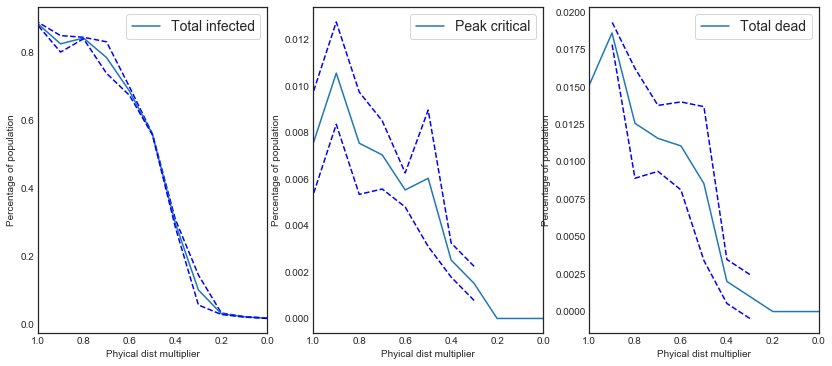

In [24]:
x = phys_dist_multiplier

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,6))

ax1.plot(x, up_total_infected, color='blue', ls='--')
ax1.plot(x, av_total_infected, label='Total infected')
ax1.plot(x, lo_total_infected, color='blue', ls='--')

ax2.plot(x, up_peak_critical, color='blue', ls='--')

ax2.plot(x, av_peak_critical, label='Peak critical')
ax2.plot(x, lo_peak_critical, color='blue', ls='--')

ax3.plot(x, up_total_dead, color='blue', ls='--')
ax3.plot(x, av_total_dead, label='Total dead')
ax3.plot(x, lo_total_dead, color='blue', ls='--')

for ax in [ax1, ax2, ax3]:
    ax.set_xlim(1.0, 0.0)
    ax.set_ylabel('Percentage of population')
    ax.set_xlabel('Phyical dist multiplier')
    ax.legend(loc='best', fontsize='14', frameon=True)
    
fig.savefig('experiment_phys_distancing.png')

## 2 Travel restriction multiplier

In [12]:
trave_restr_multiplier = [x / 10 for x in range(0, 11, 2)]
trave_restr_multiplier

[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

In [13]:
parameters["monte_carlo_runs"] = 2

In [14]:
tr_experiment = {}
for experiment in trave_restr_multiplier:
    trave_restr_mult = [experiment for x in range(len(age_groups))]
    parameters["travel_restrictions_multiplier"] = {key:value for key, value in zip(age_groups, trave_restr_mult)}
    print(parameters["travel_restrictions_multiplier"])
    #print('experiment with value: ', parameters["physical_distancing_multiplier"])
    baseline_summary_stats = []
    # Monte Carlo simulations
    for seed in range(parameters['monte_carlo_runs']):
        # make new folder for seed, if it does not exist
        if not os.path.exists('{}seed{}'.format(data_folder, seed)):
            os.makedirs('{}seed{}'.format(data_folder, seed))

        # initialization
        environment = Environment(seed, parameters, neighbourhood_data, age_distribution_per_ward, distance_matrix)

        # running the simulation
        runner(environment, seed, data_output=parameters["data_output"], data_folder=data_folder, travel_matrix=travel_matrix, verbose=False)

        # saving the network data
        for idx, network in enumerate(environment.infection_states):
            for i, node in enumerate(network.nodes):
                network.nodes[i]['agent'] = network.nodes[i]['agent'].status

        susceptible_ot = []
        infected_1_ot = []
        infected_2_ot = []
        critical_ot = []
        dead_ot = []
        recovered_ot = []
        exposed_ot = []

        for t in range(parameters['time']):
            network = environment.infection_states[t]
            susceptible = 0
            infected_1 = 0
            infected_2 = 0
            critical = 0
            dead = 0
            recovered = 0
            exposed = 0
            for idx, node in enumerate(network):
                if network.nodes[idx]['agent'] == 's':
                    susceptible += 1
                elif network.nodes[idx]['agent'] == 'e':
                    exposed += 1
                elif network.nodes[idx]['agent'] == 'i1':
                    infected_1 += 1
                elif network.nodes[idx]['agent'] == 'i2':
                    infected_2 += 1
                elif network.nodes[idx]['agent'] == 'c':
                    critical += 1
                elif network.nodes[idx]['agent'] == 'd':
                    dead += 1
                elif network.nodes[idx]['agent'] == 'r':
                    recovered +=1
                else:
                    print('no status?')

            susceptible_ot.append((susceptible / float(len(network))))
            infected_1_ot.append((infected_1 / float(len(network))))
            infected_2_ot.append((infected_2 / float(len(network))))
            critical_ot.append((critical / float(len(network))))
            dead_ot.append((dead / float(len(network))))
            recovered_ot.append((recovered / float(len(network))))
            exposed_ot.append((exposed / float(len(network))))

        # save output data
        baseline_summary_stats.append({'total dead': dead_ot[-1], 'peak critical': max(critical_ot), 'total recovered':recovered_ot[-1]})
    # add outcome to dictionary
    total_dead_baseline = [baseline_summary_stats[x]['total dead'] for x in range(len(baseline_summary_stats))]
    peak_critical_baseline = [baseline_summary_stats[x]['peak critical'] for x in range(len(baseline_summary_stats))]
    total_infected_baseline = [baseline_summary_stats[x]['total dead'] + baseline_summary_stats[x]['total recovered'] for x in range(len(baseline_summary_stats))]
    
    simulation_summary = pd.DataFrame({
    'total dead': [np.mean(total_dead_baseline), confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[0], confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[1]],
    'peak critical': [np.mean(peak_critical_baseline), confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[0], confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[1]],
    'total infected': [np.mean(total_infected_baseline), confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[0], confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[1]]
    }).transpose()
    simulation_summary.columns = ['average', 'lower', 'upper']
    
    tr_experiment[experiment] = simulation_summary

{'age_0_10': 0.0, 'age_10_20': 0.0, 'age_20_30': 0.0, 'age_30_40': 0.0, 'age_40_50': 0.0, 'age_50_60': 0.0, 'age_60_70': 0.0, 'age_70_80': 0.0, 'age_80_plus': 0.0}
{'age_0_10': 0.2, 'age_10_20': 0.2, 'age_20_30': 0.2, 'age_30_40': 0.2, 'age_40_50': 0.2, 'age_50_60': 0.2, 'age_60_70': 0.2, 'age_70_80': 0.2, 'age_80_plus': 0.2}
{'age_0_10': 0.4, 'age_10_20': 0.4, 'age_20_30': 0.4, 'age_30_40': 0.4, 'age_40_50': 0.4, 'age_50_60': 0.4, 'age_60_70': 0.4, 'age_70_80': 0.4, 'age_80_plus': 0.4}


c:\users\joeri\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1920: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
c:\users\joeri\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1921: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


{'age_0_10': 0.6, 'age_10_20': 0.6, 'age_20_30': 0.6, 'age_30_40': 0.6, 'age_40_50': 0.6, 'age_50_60': 0.6, 'age_60_70': 0.6, 'age_70_80': 0.6, 'age_80_plus': 0.6}
{'age_0_10': 0.8, 'age_10_20': 0.8, 'age_20_30': 0.8, 'age_30_40': 0.8, 'age_40_50': 0.8, 'age_50_60': 0.8, 'age_60_70': 0.8, 'age_70_80': 0.8, 'age_80_plus': 0.8}
{'age_0_10': 1.0, 'age_10_20': 1.0, 'age_20_30': 1.0, 'age_30_40': 1.0, 'age_40_50': 1.0, 'age_50_60': 1.0, 'age_60_70': 1.0, 'age_70_80': 1.0, 'age_80_plus': 1.0}


### Make a plot

In [15]:
av_total_infected_tr = [tr_experiment[x]['average'].loc['total infected'] for x in trave_restr_multiplier]
up_total_infected_tr = [tr_experiment[x]['upper'].loc['total infected'] for x in trave_restr_multiplier]
lo_total_infected_tr = [tr_experiment[x]['lower'].loc['total infected'] for x in trave_restr_multiplier]

In [16]:
av_peak_critical_tr = [tr_experiment[x]['average'].loc['peak critical'] for x in trave_restr_multiplier]
up_peak_critical_tr = [tr_experiment[x]['upper'].loc['peak critical'] for x in trave_restr_multiplier]
lo_peak_critical_tr = [tr_experiment[x]['lower'].loc['peak critical'] for x in trave_restr_multiplier]

In [17]:
av_total_dead_tr = [tr_experiment[x]['average'].loc['total dead'] for x in trave_restr_multiplier]
up_total_dead_tr = [tr_experiment[x]['upper'].loc['total dead'] for x in trave_restr_multiplier]
lo_total_dead_tr = [tr_experiment[x]['lower'].loc['total dead'] for x in trave_restr_multiplier]

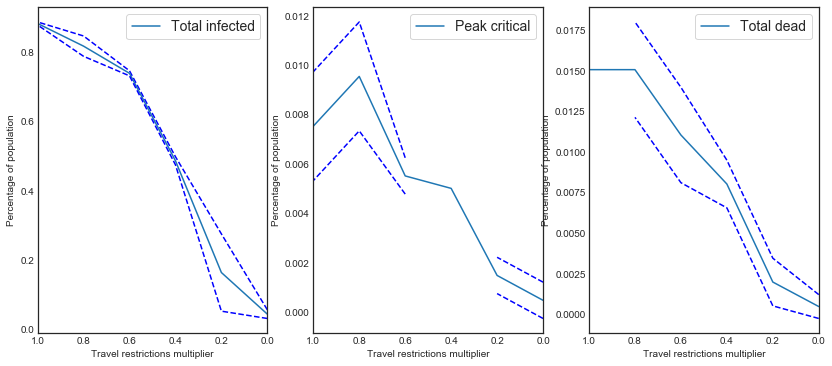

In [18]:
x = trave_restr_multiplier

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,6))

ax1.plot(x, up_total_infected_tr, color='blue', ls='--')
ax1.plot(x, av_total_infected_tr, label='Total infected')
ax1.plot(x, lo_total_infected_tr, color='blue', ls='--')

ax2.plot(x, up_peak_critical_tr, color='blue', ls='--')
ax2.plot(x, av_peak_critical_tr, label='Peak critical')
ax2.plot(x, lo_peak_critical_tr, color='blue', ls='--')

ax3.plot(x, up_total_dead_tr, color='blue', ls='--')
ax3.plot(x, av_total_dead_tr, label='Total dead')
ax3.plot(x, lo_total_dead_tr, color='blue', ls='--')

for ax in [ax1, ax2, ax3]:
    ax.set_xlim(1.0, 0.0)
    ax.set_ylabel('Percentage of population')
    ax.set_xlabel('Travel restrictions multiplier')
    ax.legend(loc='best', fontsize='14', frameon=True)
    
fig.savefig('experiment_travel_restrictions.png')

# 3 visiting_close_contacts_multiplier

In [167]:
close_contacts_multiplier = [x / 10 for x in range(0, 11, 1)]
close_contacts_multiplier

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [168]:
parameters["monte_carlo_runs"] = 10

In [169]:
cc_experiment = {}
for experiment in close_contacts_multiplier:
    parameters["visiting_close_contacts_multiplier"] = experiment
    print(parameters["visiting_close_contacts_multiplier"])
    baseline_summary_stats = []
    # Monte Carlo simulations
    for seed in range(parameters['monte_carlo_runs']):
        # make new folder for seed, if it does not exist
        if not os.path.exists('{}seed{}'.format(data_folder, seed)):
            os.makedirs('{}seed{}'.format(data_folder, seed))

        # initialization
        environment = Environment(seed, parameters, neighbourhood_data, age_distribution_per_ward, distance_matrix)

        # running the simulation
        runner(environment, seed, data_output=parameters["data_output"], data_folder=data_folder, travel_matrix=travel_matrix, verbose=False)

        # saving the network data
        for idx, network in enumerate(environment.infection_states):
            for i, node in enumerate(network.nodes):
                network.nodes[i]['agent'] = network.nodes[i]['agent'].status

        susceptible_ot = []
        infected_1_ot = []
        infected_2_ot = []
        critical_ot = []
        dead_ot = []
        recovered_ot = []
        exposed_ot = []

        for t in range(parameters['time']):
            network = environment.infection_states[t]
            susceptible = 0
            infected_1 = 0
            infected_2 = 0
            critical = 0
            dead = 0
            recovered = 0
            exposed = 0
            for idx, node in enumerate(network):
                if network.nodes[idx]['agent'] == 's':
                    susceptible += 1
                elif network.nodes[idx]['agent'] == 'e':
                    exposed += 1
                elif network.nodes[idx]['agent'] == 'i1':
                    infected_1 += 1
                elif network.nodes[idx]['agent'] == 'i2':
                    infected_2 += 1
                elif network.nodes[idx]['agent'] == 'c':
                    critical += 1
                elif network.nodes[idx]['agent'] == 'd':
                    dead += 1
                elif network.nodes[idx]['agent'] == 'r':
                    recovered +=1
                else:
                    print('no status?')

            susceptible_ot.append((susceptible / float(len(network))))
            infected_1_ot.append((infected_1 / float(len(network))))
            infected_2_ot.append((infected_2 / float(len(network))))
            critical_ot.append((critical / float(len(network))))
            dead_ot.append((dead / float(len(network))))
            recovered_ot.append((recovered / float(len(network))))
            exposed_ot.append((exposed / float(len(network))))

        # save output data
        baseline_summary_stats.append({'total dead': dead_ot[-1], 'peak critical': max(critical_ot), 'total recovered':recovered_ot[-1]})
    # add outcome to dictionary
    total_dead_baseline = [baseline_summary_stats[x]['total dead'] for x in range(len(baseline_summary_stats))]
    peak_critical_baseline = [baseline_summary_stats[x]['peak critical'] for x in range(len(baseline_summary_stats))]
    total_infected_baseline = [baseline_summary_stats[x]['total dead'] + baseline_summary_stats[x]['total recovered'] for x in range(len(baseline_summary_stats))]
    
    simulation_summary = pd.DataFrame({
    'total dead': [np.mean(total_dead_baseline), confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[0], confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[1]],
    'peak critical': [np.mean(peak_critical_baseline), confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[0], confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[1]],
    'total infected': [np.mean(total_infected_baseline), confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[0], confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[1]]
    }).transpose()
    simulation_summary.columns = ['average', 'lower', 'upper']
    
    cc_experiment[experiment] = simulation_summary

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


### Make a plot

In [170]:
av_total_infected_cc = [cc_experiment[x]['average'].loc['total infected'] for x in close_contacts_multiplier]
up_total_infected_cc = [cc_experiment[x]['upper'].loc['total infected'] for x in close_contacts_multiplier]
lo_total_infected_cc = [cc_experiment[x]['lower'].loc['total infected'] for x in close_contacts_multiplier]

In [171]:
av_peak_critical_cc = [cc_experiment[x]['average'].loc['peak critical'] for x in close_contacts_multiplier]
up_peak_critical_cc = [cc_experiment[x]['upper'].loc['peak critical'] for x in close_contacts_multiplier]
lo_peak_critical_cc = [cc_experiment[x]['lower'].loc['peak critical'] for x in close_contacts_multiplier]

In [172]:
av_total_dead_cc = [cc_experiment[x]['average'].loc['total dead'] for x in close_contacts_multiplier]
up_total_dead_cc = [cc_experiment[x]['upper'].loc['total dead'] for x in close_contacts_multiplier]
lo_total_dead_cc = [cc_experiment[x]['lower'].loc['total dead'] for x in close_contacts_multiplier]

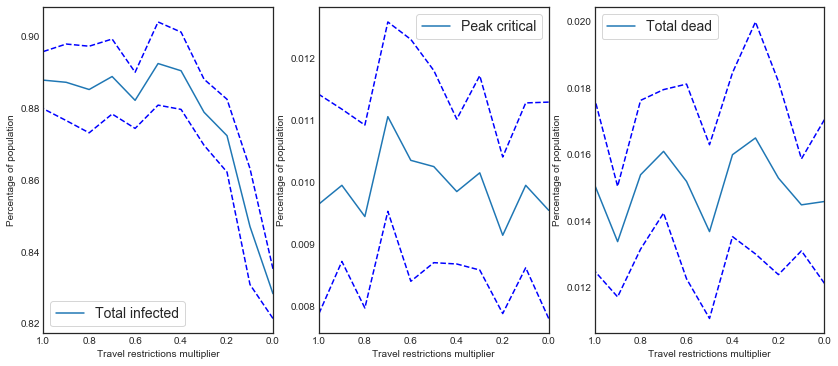

In [173]:
x = close_contacts_multiplier

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,6))

ax1.plot(x, up_total_infected_cc, color='blue', ls='--')
ax1.plot(x, av_total_infected_cc, label='Total infected')
ax1.plot(x, lo_total_infected_cc, color='blue', ls='--')

ax2.plot(x, up_peak_critical_cc, color='blue', ls='--')
ax2.plot(x, av_peak_critical_cc, label='Peak critical')
ax2.plot(x, lo_peak_critical_cc, color='blue', ls='--')

ax3.plot(x, up_total_dead_cc, color='blue', ls='--')
ax3.plot(x, av_total_dead_cc, label='Total dead')
ax3.plot(x, lo_total_dead_cc, color='blue', ls='--')

for ax in [ax1, ax2, ax3]:
    ax.set_xlim(1.0, 0.0)
    ax.set_ylabel('Percentage of population')
    ax.set_xlabel('Travel restrictions multiplier')
    ax.legend(loc='best', fontsize='14', frameon=True)
    
fig.savefig('close_contacts_travel_restrictions.png')

# 4 Testing and general awareness

In [178]:
parameters['likelihood_awareness'] = 0.6

In [176]:
s_isolation_multiplier = [x / 10 for x in range(0, 11, 1)]
s_isolation_multiplier

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [177]:
parameters["monte_carlo_runs"] = 3

In [179]:
si_experiment = {}
for experiment in s_isolation_multiplier:
    #parameters['likelihood_awareness'] = 0.6
    parameters["self_isolation_multiplier"] = experiment
    print(parameters["self_isolation_multiplier"])
    baseline_summary_stats = []
    # Monte Carlo simulations
    for seed in range(parameters['monte_carlo_runs']):
        # make new folder for seed, if it does not exist
        if not os.path.exists('{}seed{}'.format(data_folder, seed)):
            os.makedirs('{}seed{}'.format(data_folder, seed))

        # initialization
        environment = Environment(seed, parameters, neighbourhood_data, age_distribution_per_ward, distance_matrix)

        # running the simulation
        runner(environment, seed, data_output=parameters["data_output"], data_folder=data_folder, travel_matrix=travel_matrix, verbose=False)

        # saving the network data
        for idx, network in enumerate(environment.infection_states):
            for i, node in enumerate(network.nodes):
                network.nodes[i]['agent'] = network.nodes[i]['agent'].status

        susceptible_ot = []
        infected_1_ot = []
        infected_2_ot = []
        critical_ot = []
        dead_ot = []
        recovered_ot = []
        exposed_ot = []

        for t in range(parameters['time']):
            network = environment.infection_states[t]
            susceptible = 0
            infected_1 = 0
            infected_2 = 0
            critical = 0
            dead = 0
            recovered = 0
            exposed = 0
            for idx, node in enumerate(network):
                if network.nodes[idx]['agent'] == 's':
                    susceptible += 1
                elif network.nodes[idx]['agent'] == 'e':
                    exposed += 1
                elif network.nodes[idx]['agent'] == 'i1':
                    infected_1 += 1
                elif network.nodes[idx]['agent'] == 'i2':
                    infected_2 += 1
                elif network.nodes[idx]['agent'] == 'c':
                    critical += 1
                elif network.nodes[idx]['agent'] == 'd':
                    dead += 1
                elif network.nodes[idx]['agent'] == 'r':
                    recovered +=1
                else:
                    print('no status?')

            susceptible_ot.append((susceptible / float(len(network))))
            infected_1_ot.append((infected_1 / float(len(network))))
            infected_2_ot.append((infected_2 / float(len(network))))
            critical_ot.append((critical / float(len(network))))
            dead_ot.append((dead / float(len(network))))
            recovered_ot.append((recovered / float(len(network))))
            exposed_ot.append((exposed / float(len(network))))

        # save output data
        baseline_summary_stats.append({'total dead': dead_ot[-1], 'peak critical': max(critical_ot), 'total recovered':recovered_ot[-1]})
    # add outcome to dictionary
    total_dead_baseline = [baseline_summary_stats[x]['total dead'] for x in range(len(baseline_summary_stats))]
    peak_critical_baseline = [baseline_summary_stats[x]['peak critical'] for x in range(len(baseline_summary_stats))]
    total_infected_baseline = [baseline_summary_stats[x]['total dead'] + baseline_summary_stats[x]['total recovered'] for x in range(len(baseline_summary_stats))]
    
    simulation_summary = pd.DataFrame({
    'total dead': [np.mean(total_dead_baseline), confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[0], confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[1]],
    'peak critical': [np.mean(peak_critical_baseline), confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[0], confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[1]],
    'total infected': [np.mean(total_infected_baseline), confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[0], confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[1]]
    }).transpose()
    simulation_summary.columns = ['average', 'lower', 'upper']
    
    si_experiment[experiment] = simulation_summary

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


### Make a plot

In [180]:
av_total_infected_si = [si_experiment[x]['average'].loc['total infected'] for x in s_isolation_multiplier]
up_total_infected_si = [si_experiment[x]['upper'].loc['total infected'] for x in s_isolation_multiplier]
lo_total_infected_si = [si_experiment[x]['lower'].loc['total infected'] for x in s_isolation_multiplier]

In [181]:
av_peak_critical_si = [si_experiment[x]['average'].loc['peak critical'] for x in s_isolation_multiplier]
up_peak_critical_si = [si_experiment[x]['upper'].loc['peak critical'] for x in s_isolation_multiplier]
lo_peak_critical_si = [si_experiment[x]['lower'].loc['peak critical'] for x in s_isolation_multiplier]

In [182]:
av_total_dead_si = [si_experiment[x]['average'].loc['total dead'] for x in s_isolation_multiplier]
up_total_dead_si = [si_experiment[x]['upper'].loc['total dead'] for x in s_isolation_multiplier]
lo_total_dead_si = [si_experiment[x]['lower'].loc['total dead'] for x in s_isolation_multiplier]

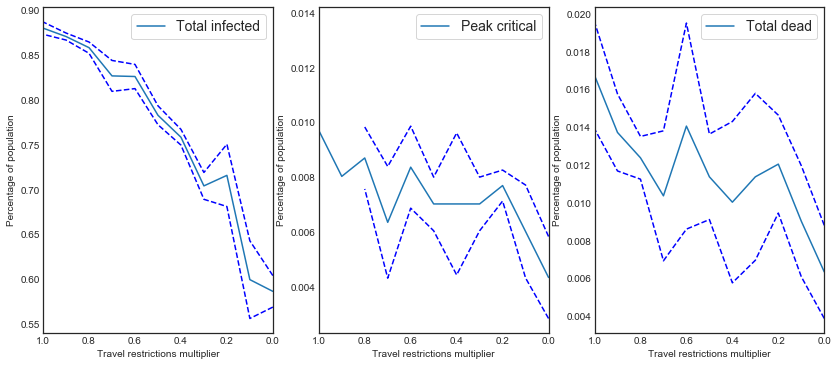

In [183]:
x = s_isolation_multiplier

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,6))

ax1.plot(x, up_total_infected_si, color='blue', ls='--')
ax1.plot(x, av_total_infected_si, label='Total infected')
ax1.plot(x, lo_total_infected_si, color='blue', ls='--')

ax2.plot(x, up_peak_critical_si, color='blue', ls='--')
ax2.plot(x, av_peak_critical_si, label='Peak critical')
ax2.plot(x, lo_peak_critical_si, color='blue', ls='--')

ax3.plot(x, up_total_dead_si, color='blue', ls='--')
ax3.plot(x, av_total_dead_si, label='Total dead')
ax3.plot(x, lo_total_dead_si, color='blue', ls='--')

for ax in [ax1, ax2, ax3]:
    ax.set_xlim(1.0, 0.0)
    ax.set_ylabel('Percentage of population')
    ax.set_xlabel('Travel restrictions multiplier')
    ax.legend(loc='best', fontsize='14', frameon=True)
    
fig.savefig('self_isolation_multiplier.png')

# 5 Limiting mass contact e.g. forbidding large events

In [ ]:
# (5) limiting mass contact e.g. forbidding large events
#parameters["gathering_max_contacts"] = 

In [200]:
gathering_max_contacts = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]#[x / 10 for x in range(0, 11, 1)]
gathering_max_contacts

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

In [201]:
parameters["monte_carlo_runs"] = 3

In [202]:
maxc_experiment = {}
for experiment in gathering_max_contacts:
    parameters["gathering_max_contacts"] = experiment
    print(parameters["gathering_max_contacts"])
    baseline_summary_stats = []
    # Monte Carlo simulations
    for seed in range(parameters['monte_carlo_runs']):
        # make new folder for seed, if it does not exist
        if not os.path.exists('{}seed{}'.format(data_folder, seed)):
            os.makedirs('{}seed{}'.format(data_folder, seed))

        # initialization
        environment = Environment(seed, parameters, neighbourhood_data, age_distribution_per_ward, distance_matrix)

        # running the simulation
        runner(environment, seed, data_output=parameters["data_output"], data_folder=data_folder, travel_matrix=travel_matrix, verbose=False)

        # saving the network data
        for idx, network in enumerate(environment.infection_states):
            for i, node in enumerate(network.nodes):
                network.nodes[i]['agent'] = network.nodes[i]['agent'].status

        susceptible_ot = []
        infected_1_ot = []
        infected_2_ot = []
        critical_ot = []
        dead_ot = []
        recovered_ot = []
        exposed_ot = []

        for t in range(parameters['time']):
            network = environment.infection_states[t]
            susceptible = 0
            infected_1 = 0
            infected_2 = 0
            critical = 0
            dead = 0
            recovered = 0
            exposed = 0
            for idx, node in enumerate(network):
                if network.nodes[idx]['agent'] == 's':
                    susceptible += 1
                elif network.nodes[idx]['agent'] == 'e':
                    exposed += 1
                elif network.nodes[idx]['agent'] == 'i1':
                    infected_1 += 1
                elif network.nodes[idx]['agent'] == 'i2':
                    infected_2 += 1
                elif network.nodes[idx]['agent'] == 'c':
                    critical += 1
                elif network.nodes[idx]['agent'] == 'd':
                    dead += 1
                elif network.nodes[idx]['agent'] == 'r':
                    recovered +=1
                else:
                    print('no status?')

            susceptible_ot.append((susceptible / float(len(network))))
            infected_1_ot.append((infected_1 / float(len(network))))
            infected_2_ot.append((infected_2 / float(len(network))))
            critical_ot.append((critical / float(len(network))))
            dead_ot.append((dead / float(len(network))))
            recovered_ot.append((recovered / float(len(network))))
            exposed_ot.append((exposed / float(len(network))))

        # save output data
        baseline_summary_stats.append({'total dead': dead_ot[-1], 'peak critical': max(critical_ot), 'total recovered':recovered_ot[-1]})
    # add outcome to dictionary
    total_dead_baseline = [baseline_summary_stats[x]['total dead'] for x in range(len(baseline_summary_stats))]
    peak_critical_baseline = [baseline_summary_stats[x]['peak critical'] for x in range(len(baseline_summary_stats))]
    total_infected_baseline = [baseline_summary_stats[x]['total dead'] + baseline_summary_stats[x]['total recovered'] for x in range(len(baseline_summary_stats))]
    
    simulation_summary = pd.DataFrame({
    'total dead': [np.mean(total_dead_baseline), confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[0], confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[1]],
    'peak critical': [np.mean(peak_critical_baseline), confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[0], confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[1]],
    'total infected': [np.mean(total_infected_baseline), confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[0], confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[1]]
    }).transpose()
    simulation_summary.columns = ['average', 'lower', 'upper']
    
    maxc_experiment[experiment] = simulation_summary

2
4
6
8
10
12
14
16
18
20


### Make a plot

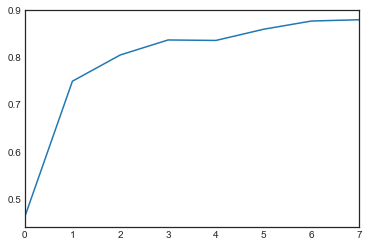

In [197]:
#pd.Series(av_total_infected_maxc).plot()

In [203]:
av_total_infected_maxc = [maxc_experiment[x]['average'].loc['total infected'] for x in gathering_max_contacts]
up_total_infected_maxc = [maxc_experiment[x]['upper'].loc['total infected'] for x in gathering_max_contacts]
lo_total_infected_maxc = [maxc_experiment[x]['lower'].loc['total infected'] for x in gathering_max_contacts]

In [204]:
av_peak_critical_maxc = [maxc_experiment[x]['average'].loc['peak critical'] for x in gathering_max_contacts]
up_peak_critical_maxc = [maxc_experiment[x]['upper'].loc['peak critical'] for x in gathering_max_contacts]
lo_peak_critical_maxc = [maxc_experiment[x]['lower'].loc['peak critical'] for x in gathering_max_contacts]

In [205]:
av_total_dead_maxc = [maxc_experiment[x]['average'].loc['total dead'] for x in gathering_max_contacts]
up_total_dead_maxc = [maxc_experiment[x]['upper'].loc['total dead'] for x in gathering_max_contacts]
lo_total_dead_maxc = [maxc_experiment[x]['lower'].loc['total dead'] for x in gathering_max_contacts]

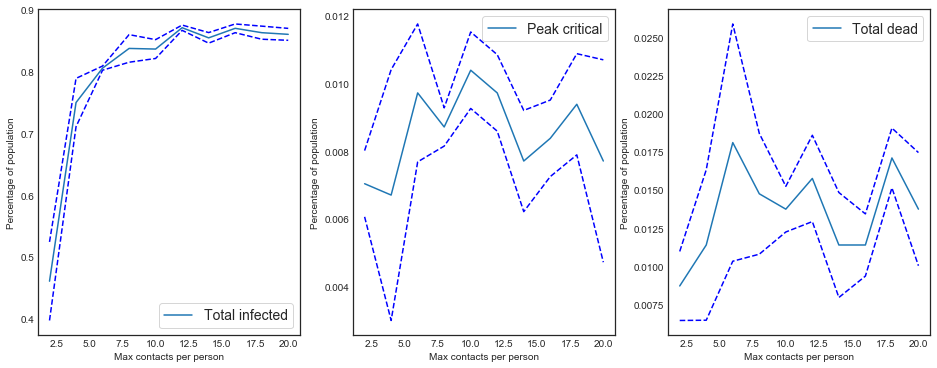

In [209]:
x = gathering_max_contacts

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6))

ax1.plot(x, up_total_infected_maxc, color='blue', ls='--')
ax1.plot(x, av_total_infected_maxc, label='Total infected')
ax1.plot(x, lo_total_infected_maxc, color='blue', ls='--')

ax2.plot(x, up_peak_critical_maxc, color='blue', ls='--')
ax2.plot(x, av_peak_critical_maxc, label='Peak critical')
ax2.plot(x, lo_peak_critical_maxc, color='blue', ls='--')

ax3.plot(x, up_total_dead_maxc, color='blue', ls='--')
ax3.plot(x, av_total_dead_maxc, label='Total dead')
ax3.plot(x, lo_total_dead_maxc, color='blue', ls='--')

for ax in [ax1, ax2, ax3]:
    #ax.set_xlim(1.0, 0.0)
    ax.set_ylabel('Percentage of population')
    ax.set_xlabel('Max contacts per person')
    ax.legend(loc='best', fontsize='14', frameon=True)
    
fig.savefig('maxcontacts_experiment.png')

# Use switch on several measures: 

First, make sure all parameters are set to the default where they have no effect.

In [27]:
parameters["lockdown_days"] = [x for x in range(0, parameters['time'])]
# (1) physical distancing measures such as increased hygiëne & face mask adoption 
parameters["physical_distancing_multiplier"] = 1.0
# (2) reducing travel e.g. by reducing it for work, school or all
parameters["travel_restrictions_multiplier"] = {key:value for key, value in zip(age_groups, 
                                                                                [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])} 
# (3) reducing close contacts 
parameters["visiting_close_contacts_multiplier"] = 1.0 # depending on how strict the lockdown is at keeping you put.
# (4) Testing and general awareness
parameters['likelihood_awareness'] = 0.0 # this will be increased through track & trace and coviid
parameters['self_isolation_multiplier'] = 1.0 # determines the percentage of connections cut thanks to self-isoluation can go up with coviid
parameters['aware_status'] = ['i2'] # i1 can be added if there is large scale testing 
# (5) limiting mass contact e.g. forbidding large events
parameters["gathering_max_contacts"] = 5000

Let's imagine using all instruments but at low strenght

In [28]:
parameters["monte_carlo_runs"] = 3

In [29]:
phases = [x for x in range(6)]
phases

[0, 1, 2, 3, 4, 5]

In [30]:
total_experiment = {}
for experiment in phases:
    print('experiment: ', experiment)
    if experiment == 1:
        parameters["physical_distancing_multiplier"] = 0.8
    print(parameters["physical_distancing_multiplier"])
    if experiment == 2: 
        trave_restr_mult = [0.8 for x in range(len(age_groups))]
        parameters["travel_restrictions_multiplier"] = {key:value for key, value in zip(age_groups, trave_restr_mult)}
    print(parameters["travel_restrictions_multiplier"])
    if experiment == 3:
        parameters["visiting_close_contacts_multiplier"] = 0.8
    print(parameters["visiting_close_contacts_multiplier"])
    if experiment == 4:
        parameters['likelihood_awareness'] = 0.6
        parameters["self_isolation_multiplier"] = 0.8
    print(parameters["self_isolation_multiplier"])
    if experiment == 5:
        parameters["gathering_max_contacts"] = 8
    print(parameters["gathering_max_contacts"])
    
    #print('experiment with value: ', parameters["physical_distancing_multiplier"])
    baseline_summary_stats = []
    # Monte Carlo simulations
    for seed in range(parameters['monte_carlo_runs']):
        # make new folder for seed, if it does not exist
        if not os.path.exists('{}seed{}'.format(data_folder, seed)):
            os.makedirs('{}seed{}'.format(data_folder, seed))

        # initialization
        environment = Environment(seed, parameters, neighbourhood_data, age_distribution_per_ward, distance_matrix)

        # running the simulation
        runner(environment, seed, data_output=parameters["data_output"], data_folder=data_folder, travel_matrix=travel_matrix, verbose=False)

        # saving the network data
        for idx, network in enumerate(environment.infection_states):
            for i, node in enumerate(network.nodes):
                network.nodes[i]['agent'] = network.nodes[i]['agent'].status

        susceptible_ot = []
        infected_1_ot = []
        infected_2_ot = []
        critical_ot = []
        dead_ot = []
        recovered_ot = []
        exposed_ot = []

        for t in range(parameters['time']):
            network = environment.infection_states[t]
            susceptible = 0
            infected_1 = 0
            infected_2 = 0
            critical = 0
            dead = 0
            recovered = 0
            exposed = 0
            for idx, node in enumerate(network):
                if network.nodes[idx]['agent'] == 's':
                    susceptible += 1
                elif network.nodes[idx]['agent'] == 'e':
                    exposed += 1
                elif network.nodes[idx]['agent'] == 'i1':
                    infected_1 += 1
                elif network.nodes[idx]['agent'] == 'i2':
                    infected_2 += 1
                elif network.nodes[idx]['agent'] == 'c':
                    critical += 1
                elif network.nodes[idx]['agent'] == 'd':
                    dead += 1
                elif network.nodes[idx]['agent'] == 'r':
                    recovered +=1
                else:
                    print('no status?')

            susceptible_ot.append((susceptible / float(len(network))))
            infected_1_ot.append((infected_1 / float(len(network))))
            infected_2_ot.append((infected_2 / float(len(network))))
            critical_ot.append((critical / float(len(network))))
            dead_ot.append((dead / float(len(network))))
            recovered_ot.append((recovered / float(len(network))))
            exposed_ot.append((exposed / float(len(network))))

        # save output data
        baseline_summary_stats.append({'total dead': dead_ot[-1], 'peak critical': max(critical_ot), 'total recovered':recovered_ot[-1]})
    # add outcome to dictionary
    total_dead_baseline = [baseline_summary_stats[x]['total dead'] for x in range(len(baseline_summary_stats))]
    peak_critical_baseline = [baseline_summary_stats[x]['peak critical'] for x in range(len(baseline_summary_stats))]
    total_infected_baseline = [baseline_summary_stats[x]['total dead'] + baseline_summary_stats[x]['total recovered'] for x in range(len(baseline_summary_stats))]
    
    simulation_summary = pd.DataFrame({
    'total dead': [np.mean(total_dead_baseline), confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[0], confidence_interval(total_dead_baseline, np.mean(total_dead_baseline))[1]],
    'peak critical': [np.mean(peak_critical_baseline), confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[0], confidence_interval(peak_critical_baseline, np.mean(peak_critical_baseline))[1]],
    'total infected': [np.mean(total_infected_baseline), confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[0], confidence_interval(total_infected_baseline, np.mean(total_infected_baseline))[1]]
    }).transpose()
    simulation_summary.columns = ['average', 'lower', 'upper']
    
    total_experiment[experiment] = simulation_summary

experiment:  0
1.0
{'age_0_10': 1.0, 'age_10_20': 1.0, 'age_20_30': 1.0, 'age_30_40': 1.0, 'age_40_50': 1.0, 'age_50_60': 1.0, 'age_60_70': 1.0, 'age_70_80': 1.0, 'age_80_plus': 1.0}
1.0
1.0
5000
experiment:  1
0.8
{'age_0_10': 1.0, 'age_10_20': 1.0, 'age_20_30': 1.0, 'age_30_40': 1.0, 'age_40_50': 1.0, 'age_50_60': 1.0, 'age_60_70': 1.0, 'age_70_80': 1.0, 'age_80_plus': 1.0}
1.0
1.0
5000
experiment:  2
0.8
{'age_0_10': 0.8, 'age_10_20': 0.8, 'age_20_30': 0.8, 'age_30_40': 0.8, 'age_40_50': 0.8, 'age_50_60': 0.8, 'age_60_70': 0.8, 'age_70_80': 0.8, 'age_80_plus': 0.8}
1.0
1.0
5000
experiment:  3
0.8
{'age_0_10': 0.8, 'age_10_20': 0.8, 'age_20_30': 0.8, 'age_30_40': 0.8, 'age_40_50': 0.8, 'age_50_60': 0.8, 'age_60_70': 0.8, 'age_70_80': 0.8, 'age_80_plus': 0.8}
0.8
1.0
5000
experiment:  4
0.8
{'age_0_10': 0.8, 'age_10_20': 0.8, 'age_20_30': 0.8, 'age_30_40': 0.8, 'age_40_50': 0.8, 'age_50_60': 0.8, 'age_60_70': 0.8, 'age_70_80': 0.8, 'age_80_plus': 0.8}
0.8
0.8
5000
experiment:  5
0.8
{

### Make a plot

In [31]:
av_total_infected_all = [total_experiment[x]['average'].loc['total infected'] for x in phases]
up_total_infected_all = [total_experiment[x]['upper'].loc['total infected'] for x in phases]
lo_total_infected_all = [total_experiment[x]['lower'].loc['total infected'] for x in phases]

In [32]:
av_peak_critical_all = [total_experiment[x]['average'].loc['peak critical'] for x in phases]
up_peak_critical_all = [total_experiment[x]['upper'].loc['peak critical'] for x in phases]
lo_peak_critical_all = [total_experiment[x]['lower'].loc['peak critical'] for x in phases]

In [35]:
av_total_dead_all = [total_experiment[x]['average'].loc['total dead'] for x in phases]
up_total_dead_all = [total_experiment[x]['upper'].loc['total dead'] for x in phases]
lo_total_dead_all = [total_experiment[x]['lower'].loc['total dead'] for x in phases]

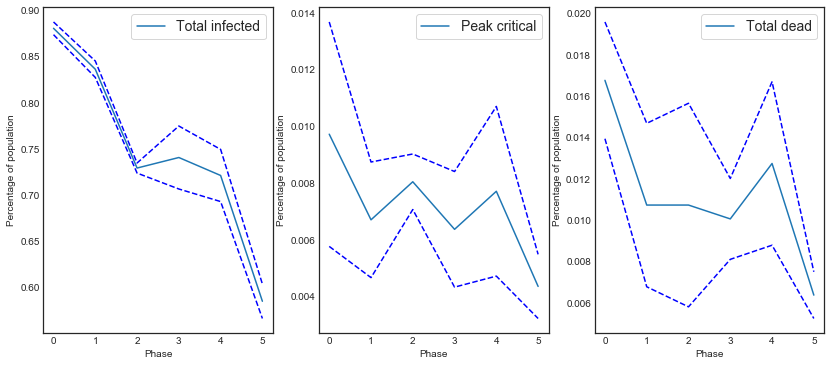

In [37]:
x = phases

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,6))

ax1.plot(x, up_total_infected_all, color='blue', ls='--')
ax1.plot(x, av_total_infected_all, label='Total infected')
ax1.plot(x, lo_total_infected_all, color='blue', ls='--')

ax2.plot(x, up_peak_critical_all, color='blue', ls='--')
ax2.plot(x, av_peak_critical_all, label='Peak critical')
ax2.plot(x, lo_peak_critical_all, color='blue', ls='--')

ax3.plot(x, up_total_dead_all, color='blue', ls='--')
ax3.plot(x, av_total_dead_all, label='Total dead')
ax3.plot(x, lo_total_dead_all, color='blue', ls='--')

for ax in [ax1, ax2, ax3]:
    #ax.set_xlim(1.0, 0.0)
    ax.set_ylabel('Percentage of population')
    ax.set_xlabel('Phase')
    ax.legend(loc='best', fontsize='14', frameon=True)
    
fig.savefig('total_experiment.png')